In [1]:
import pandas as pd
%pylab inline
import pickle

Populating the interactive namespace from numpy and matplotlib


In [2]:
abstracts_df = pd.read_pickle('abstracts1.pkl')
abstracts_df.describe()

,Issue,Journal,Pages,Volume,abstract,category,date,doi,title
count,27412,27412,27412,27412,27412,27412,27412,27412,27412
unique,32,1,18241,127,27412,702,734,27412,27233
top,Issue 1,Journal of Animal Science,Pages 1–8,Volume 94,The effects of estrogen and progesterone on th...,Ruminant Nutrition,2016-09-01 00:00:00,https://doi.org/10.2527/1996.7461274x,Discussion
freq,4709,27412,23,1194,1,4008,291,1,31
first,NaN,NaN,NaN,NaN,NaN,NaN,1910-01-01 00:00:00,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,NaN,2018-07-28 00:00:00,NaN,NaN


In [3]:
abstracts_df.index = range(len(abstracts_df.index))

In [4]:
abstracts_df.head()

,Issue,Journal,Pages,Volume,abstract,category,date,doi,title
0,Issue 1,Journal of Animal Science,Pages 391,Volume 1940,"Edward Browning Meigs died November 5, 1940. B...",Business Meeting,1940-12-01,https://doi.org/10.2527/jas1940.19401391x,Edward Browning Meigs
1,Issue 1,Journal of Animal Science,Pages 175–180,Volume 1939,Approximately 38 percent of the total land are...,Sheep and Wool,1939-12-01,https://doi.org/10.2527/jas1939.19391175x,The Production and Marketing of Feeder Lambs i...
2,Issue 1,Journal of Animal Science,Pages 412,Volume 1933,"Harry Hayward, N. W. Ayer &amp; Son, 308 Chest...",Article,1933-01-01,https://doi.org/10.2527/jas1933.19331412x,In Memoriam
3,Issue 8,Journal of Animal Science,Pages 3503–3512,Volume 96,Data from a recent survey suggest that the maj...,Symposia,2018-07-28,https://doi.org/10.1093/jas/sky026,Forages and pastures symposium: cover crops in...
4,Issue 1,Journal of Animal Science,Pages 231–232,Volume 1928,"Saturday Afternoon, November 26, 1927The twent...",Committee and Business Reports,1928-01-01,https://doi.org/10.2527/jas1928.19281231x,Minutes of the Twentieth Annual Business Meeting


In [5]:
# Save just the abstract text for app
abstracts = abstracts_df['abstract']
# abstracts.index = range(len(abstracts.index)) - shouldn't need since already reindexed 

In [6]:
abstracts_df.to_pickle('jas_df.pkl')
abstracts.to_pickle('jas_abstracts.pkl')

# KEY FUNCTIONS

In [7]:
#  more stop words
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import string
from nltk.tag import pos_tag

def noun_tokenizer(text):

    # remove punctuation
    punct = string.punctuation + '±−≤°≥“”'
    remove_punct = str.maketrans('', '', punct)
    text = text.translate(remove_punct)

    # remove digits and convert to lower case
    remove_digits = str.maketrans('', '', string.digits)
    text = text.lower().translate(remove_digits)

    # tokenize
    tokens = word_tokenize(text)

    is_noun = lambda pos: (pos == 'NN') | (pos == 'NNS') #only nouns - no proper nouns
    nouns = [word for (word, pos) in pos_tag(tokens) if is_noun(pos)]
    # remove stop words
    stop_words = stopwords.words('english')
    JAS_words = ['use', 'model', 'anim', 'method', 'result', 'kg', 'vs', 'treatment', 'mgkg', 'per', 'h', 'x']
    more_words = ['et', 'al', 'mg', 'cm', 'animals', 'animal', 'mm', 'experiment','treatments','containing', 'studies', 'added', 'sources', 'total', 'science', 'research', 'field', 'degree','report', 'greater', 'increased', 'decreased', 'less', 'use', 'production', 'agriculture']
    stop_words = stop_words + JAS_words + more_words
    tokens_stop = [y for y in nouns if y not in stop_words]

    return tokens_stop

In [26]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF

def tfidf_and_nmf(corpus, tokenizer, components=40, max_df=0.8, min_df=2, seed=2019):
    '''*Input*
    corpus: List of documents,
    tokenizer: tokenize function,
    components: int, number of components to use, 40 looked pretty good
    max_df: float, threshold to ignore terms,
    min_df: int, a token must appear in at least this many documents
    
    *Output*
    tuple(vocab, nmf model, Nxk matrix)
    '''
    # countvectorizing and training
    tfidf = TfidfVectorizer(tokenizer=noun_tokenizer, max_df=max_df, min_df=min_df)
    X_train_tfidf = tfidf.fit_transform(corpus)
    
    # flip key:index to allow for lookup using index
    vocab = dict((v, k) for k, v in tfidf.vocabulary_.items())
    nmf = NMF(n_components=components, random_state=seed)
    nmf_vecs = nmf.fit_transform(X_train_tfidf)
    return vocab, nmf, nmf_vecs, tfidf

In [28]:
#fit data and find topics
%time abstracts_vocab, abstracts_nmf, abstracts_vecs, jas_tfidf = tfidf_and_nmf(abstracts, noun_tokenizer, components=30)

CPU times: user 15min 16s, sys: 2.94 s, total: 15min 19s
Wall time: 14min 36s


In [29]:
with open('JAS_vocab.pkl', 'wb') as picklefile:
    pickle.dump(abstracts_vocab, picklefile)

In [30]:
with open('JAS_nmf.pkl', 'wb') as picklefile:
    pickle.dump(abstracts_nmf, picklefile)
with open('JAS_vecs.pkl', 'wb') as picklefile:
    pickle.dump(abstracts_vecs, picklefile)
with open('JAS_tfidf.pkl', 'wb') as picklefile:
    pickle.dump(jas_tfidf, picklefile)

In [31]:
# confirm size of data is the same
len(abstracts_vecs)

27412

In [32]:
# argsort gives you the indices of the sorted order in ascending order, taking negative  makes it desc
nmf_topic_words = [topic[:15] for topic in np.argsort(-abstracts_nmf.components_)]

In [33]:
# np.argsort(-abstracts_nmf.components_)

In [34]:
#show top 15 words in each topic by looking up index in the vocab dictionary
for i, component in enumerate(nmf_topic_words):
     print(i, [abstracts_vocab[idx] for idx in component])

0 ['p', 'lt', 'bw', 'gt', 'diets', 'supplementation', 'n', 'adg', 'cp', 'control', 'effects', 'phytase', 'con', 'gf', 'dm']
1 ['weight', 'birth', 'age', 'weights', 'breed', 'heterosis', 'breeds', 'body', 'dam', 'growth', 'dams', 'gain', 'calf', 'sex', 'effects']
2 ['pigs', 'diets', 'pig', 'diet', 'performance', 'growth', 'feed', 'adg', 'barrows', 'adfi', 'gf', 'exp', 'period', 'wk', 'control']
3 ['ration', 'rations', 'feed', 'gain', 'percent', 'phosphorus', 'gains', 'calcium', 'meal', 'levels', 'level', 'efficiency', 'rate', 'trials', 'hay']
4 ['days', 'day', 'estrus', 'progesterone', 'cycle', 'ovulation', 'group', 'follicles', 'cl', 'injection', 'groups', 'corpora', 'period', 'interval', 'hr']
5 ['cows', 'cow', 'postpartum', 'bcs', 'calf', 'pregnancy', 'beef', 'estrus', 'condition', 'gnrh', 'conception', 'hereford', 'dairy', 'rates', 'interval']
6 ['sows', 'lactation', 'gestation', 'piglets', 'litter', 'sow', 'parity', 'litters', 'piglet', 'size', 'number', 'parturition', 'farrowing',

# Label Components and visualize --in progress--

In [35]:
abstracts_vecs.shape

(27412, 30)

In [36]:
abstracts_vecs.argmax(axis=1)

array([22, 14, 28, ...,  5, 10,  6])

In [37]:
import seaborn as sns
sns.set()

/home/douglas/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


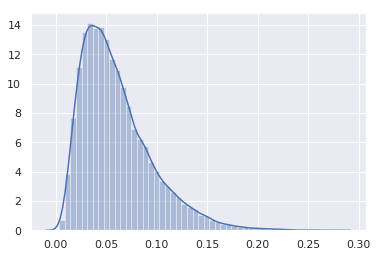

In [38]:
# How much does biggest component contribute to the text?
sns.distplot(abstracts_vecs.max(axis=1))

In [56]:
component_labels = {0:'Feeding Trial(Generic)',
                      1:'Cattle Offspring',
                      2:'Feeding Trial(Pig)',
                      3: 'Feed Formulation',
                      4:'Estrous Cycle',
                     5:'Cattle Offspring',
                     6:'Sow Offspring',
                     7:'Cattle Feedlot',
                     8:'Meat and Carcass',
                   9:'Genetics and Selection',
                   10:'Cattle Offspring',
                   11:'Cattle Offspring',
                   12:'Sow Offspring',
                   13: 'Grains and Silage',
                   14: 'Not Research',
                   15:'Feed Formulation',
                   16:'Sheep',
                   17:'Blood Samples',
                   18:'Muscle tissues',
                   19:'Milk',
                   20:'Sheep',
                   21:'Bull Semen',
                   22:'Feed Formulation',
                   23:'Meat and Carcass',
                    24:'Feed Formulation',
                    25:'Feeding Trial(Generic)',
                    26:'Minerals',
                    27:'Feed Formulation',
                    28:'Vitamins',
                    29:'Genetics and Selection',
                   }

In [76]:
labels = pd.DataFrame()

In [85]:
labels = labels.from_dict(component_labels, orient='index', columns=['Topic'])

In [57]:
# np.unique(abstracts_vecs.argmax(axis=1), return_counts=True)
pd.Series(abstracts_vecs.argmax(axis=1)).value_counts()

14    2640
2     1976
18    1831
15    1724
9     1353
5     1180
24    1060
27    1059
7     1007
23     997
25     919
17     865
6      767
29     753
10     734
21     721
20     711
16     694
8      690
3      665
22     658
28     625
12     606
19     605
13     571
11     565
26     478
1      395
4      327
0      236
dtype: int64

To do:  
    1) Attach vectors to dataframe.  
    2) Assign topic (simple max?)   
    3) Plot by date to get topic evolution.

In [39]:
# How important are the secondary components?

In [40]:
sorted_vecs = np.sort(abstracts_vecs)

In [41]:
sorted_vecs.shape

(27412, 30)

In [42]:
((sorted_vecs[:,-1] - sorted_vecs[:,-2])/sorted_vecs[:,-1]).mean()

0.46658900955143967

In [44]:
((sorted_vecs[:,-2])/sorted_vecs[:,-1]).mean() # 2nd about half the contribution of the 1st component on avg

0.5334109904485603

In [47]:
((sorted_vecs[:,-2])/sorted_vecs[:,-1]).std() 

0.2678296746635765

In [48]:
print(((sorted_vecs[:,-3])/sorted_vecs[:,-1]).mean()) # 3rd drops to 1/3
((sorted_vecs[:,-3])/sorted_vecs[:,-1]).std()

0.3321576112371818


0.2172088707634704

In [52]:
for i in range(1,15):
    print(i, ((sorted_vecs[:,-i])/sorted_vecs[:,-1]).mean(), ((sorted_vecs[:,-i])/sorted_vecs[:,-1]).std())
# topics relevance go down very quickly

1 1.0 0.0
2 0.5334109904485603 0.2678296746635765
3 0.3321576112371818 0.2172088707634704
4 0.2203333189165732 0.16903134492152389
5 0.150992156942039 0.13195300697432036
6 0.10499905343323818 0.10303227240420168
7 0.07441742612968356 0.08197131734042915
8 0.053127005274487944 0.06508542433560176
9 0.03839246076058345 0.05238656761481047
10 0.02808544331672819 0.04272359919624943
11 0.02051121546526202 0.03454246799522136
12 0.014917583820226303 0.028191235716577244
13 0.010812936011642304 0.023006408254871852
14 0.007745402862297164 0.018677569120132718


In [54]:
# add top component as cluster to dataframe - very simple interpretation of the topics 
abstracts_df['top_component'] = abstracts_vecs.argmax(axis=1)

In [88]:
abstracts_df.shape

(27412, 11)

In [55]:
abstracts_df.head()

,Issue,Journal,Pages,Volume,abstract,category,date,doi,title,top_component
0,Issue 1,Journal of Animal Science,Pages 391,Volume 1940,"Edward Browning Meigs died November 5, 1940. B...",Business Meeting,1940-12-01,https://doi.org/10.2527/jas1940.19401391x,Edward Browning Meigs,22
1,Issue 1,Journal of Animal Science,Pages 175–180,Volume 1939,Approximately 38 percent of the total land are...,Sheep and Wool,1939-12-01,https://doi.org/10.2527/jas1939.19391175x,The Production and Marketing of Feeder Lambs i...,14
2,Issue 1,Journal of Animal Science,Pages 412,Volume 1933,"Harry Hayward, N. W. Ayer &amp; Son, 308 Chest...",Article,1933-01-01,https://doi.org/10.2527/jas1933.19331412x,In Memoriam,28
3,Issue 8,Journal of Animal Science,Pages 3503–3512,Volume 96,Data from a recent survey suggest that the maj...,Symposia,2018-07-28,https://doi.org/10.1093/jas/sky026,Forages and pastures symposium: cover crops in...,13
4,Issue 1,Journal of Animal Science,Pages 231–232,Volume 1928,"Saturday Afternoon, November 26, 1927The twent...",Committee and Business Reports,1928-01-01,https://doi.org/10.2527/jas1928.19281231x,Minutes of the Twentieth Annual Business Meeting,14


In [101]:
%time labeled = abstracts_df.merge(labels, left_on='top_component', right_index=True)
# join is 4x slower in this case

CPU times: user 40.2 ms, sys: 3.96 ms, total: 44.1 ms
Wall time: 47.1 ms


In [102]:
%time abstracts_df['Topic'] = abstracts_df['top_component'].map(component_labels)

CPU times: user 5.5 ms, sys: 4.01 ms, total: 9.51 ms
Wall time: 11.7 ms


In [103]:
abstracts_df.head()

,Issue,Journal,Pages,Volume,abstract,category,date,doi,title,top_component,year,Topic
0,Issue 1,Journal of Animal Science,Pages 391,Volume 1940,"Edward Browning Meigs died November 5, 1940. B...",Business Meeting,1940-12-01,https://doi.org/10.2527/jas1940.19401391x,Edward Browning Meigs,22,1940,Feed Formulation
1,Issue 1,Journal of Animal Science,Pages 175–180,Volume 1939,Approximately 38 percent of the total land are...,Sheep and Wool,1939-12-01,https://doi.org/10.2527/jas1939.19391175x,The Production and Marketing of Feeder Lambs i...,14,1939,Not Research
2,Issue 1,Journal of Animal Science,Pages 412,Volume 1933,"Harry Hayward, N. W. Ayer &amp; Son, 308 Chest...",Article,1933-01-01,https://doi.org/10.2527/jas1933.19331412x,In Memoriam,28,1933,Vitamins
3,Issue 8,Journal of Animal Science,Pages 3503–3512,Volume 96,Data from a recent survey suggest that the maj...,Symposia,2018-07-28,https://doi.org/10.1093/jas/sky026,Forages and pastures symposium: cover crops in...,13,2018,Grains and Silage
4,Issue 1,Journal of Animal Science,Pages 231–232,Volume 1928,"Saturday Afternoon, November 26, 1927The twent...",Committee and Business Reports,1928-01-01,https://doi.org/10.2527/jas1928.19281231x,Minutes of the Twentieth Annual Business Meeting,14,1928,Not Research


In [104]:
abstracts_df[['abstract', 'date', 'title', 'category', 'Topic']].to_csv('abstracts.csv')

In [63]:
abstracts_df['year'] = abstracts_df['date'].dt.year

# Journal of Animal Science Topic Popularity Through Time
https://public.tableau.com/profile/douglas.lee2850#!/vizhome/JournalofAnimalScienceTopicPopularityThroughTime/JASTopicPopularity?publish=yes